In [1]:
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn.functional as F
import numpy as np

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("drive/My Drive/Comp Medicine Project")

In [4]:
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(70, 1) # output is number channels
        self.fc2 = torch.nn.Linear(19, 4)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.transpose(x,-1,-2)
        x = self.fc2(x)
        return x


In [5]:
X = np.load('x_train_power.npy')
Y = np.load('y_train.npy')

In [6]:
def test_model():
    model = BaselineModel()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    
    labels = F.one_hot(torch.Tensor(Y).type(torch.long)).type(torch.float)
    train_set = TensorDataset(torch.Tensor(X).type(torch.float), labels)
    train_loader = DataLoader(dataset=train_set, shuffle=True)

    for epoch in range(10):
        running_loss = 0
        correct = 0
        for i, data in enumerate(train_loader):
            x_batch, y_batch = data

            optimizer.zero_grad()
            yhat = model(x_batch) 
            # print(yhat.shape, y_batch.shape)
            loss = criterion(yhat[0], y_batch.type(torch.float))
            loss.backward()
            optimizer.step()
            correct += (torch.argmax(yhat[0], dim=1) == torch.argmax(y_batch, dim=1)).float().sum()
            running_loss += loss.item()
            

        acc = correct / len(train_set)
        print('(%d) loss= %.3f; accuracy = %.1f%%' % (epoch, loss, 100 * acc))
    
    test_X = np.load('x_test_power.npy')
    test_Y = np.load('y_test.npy')
    
    labels = F.one_hot(torch.Tensor(test_Y).type(torch.long)).type(torch.float)
    test_set = TensorDataset(torch.Tensor(test_X).type(torch.float), labels)
    test_loader = DataLoader(dataset=test_set)
    correct = 0
    for i, data in enumerate(test_loader):
        x_batch, y_batch = data
        yhat = model(x_batch) 
        # print(yhat.shape, y_batch.shape)
        correct += (torch.argmax(yhat[0], dim=1) == torch.argmax(y_batch, dim=1)).float().sum()

    print(correct, len(test_set))
    acc = correct / len(test_set)
    print('(%d) loss= %.3f; accuracy = %.1f%%' % (100, loss, 100 * acc))

In [7]:
test_model()

(0) loss= 0.501; accuracy = 63.2%
(1) loss= 0.215; accuracy = 83.3%
(2) loss= 0.031; accuracy = 85.5%
(3) loss= 0.095; accuracy = 86.1%
(4) loss= 0.474; accuracy = 86.1%
(5) loss= 0.039; accuracy = 86.9%
(6) loss= 0.716; accuracy = 87.0%
(7) loss= 0.021; accuracy = 87.0%
(8) loss= 0.139; accuracy = 87.4%
(9) loss= 0.432; accuracy = 87.3%
tensor(681.) 779
(100) loss= 0.432; accuracy = 87.4%


In [8]:
from torchsummary import summary
model = BaselineModel()
print(summary(model, input_size=(19, 70)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 19, 1]              71
            Linear-2                 [-1, 1, 4]              80
Total params: 151
Trainable params: 151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
None


# CNN

In [9]:
import torch.nn as nn 

In [10]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    
    self.cnn1 = nn.Conv1d(in_channels=19, out_channels=21, kernel_size=3, stride=1, padding=0)
    self.relu1 = nn.ReLU() 
    self.cnn2 = nn.Conv1d(in_channels=21, out_channels=23, kernel_size=3, stride=1, padding=0)
    self.relu2 = nn.ReLU()  
  

    self.fc1 = torch.nn.Linear(1518, 128)
    self.fc2 = torch.nn.Linear(128, 4)

  def forward(self,x):

    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.cnn2(out)      
    out = self.relu2(out)

    out = out.view(out.size(0), -1)


    out = self.fc1(out)
    out = self.fc2(out)      
    #out = self.fc3(out)
    #out = self.fc4(out)
    #out = self.fc5(out)
    
    return out

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

error = torch.nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

In [12]:
from torchsummary import summary
print(summary(model, input_size=(19, 70)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 21, 68]           1,218
              ReLU-2               [-1, 21, 68]               0
            Conv1d-3               [-1, 23, 66]           1,472
              ReLU-4               [-1, 23, 66]               0
            Linear-5                  [-1, 128]         194,432
            Linear-6                    [-1, 4]             516
Total params: 197,638
Trainable params: 197,638
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.75
Estimated Total Size (MB): 0.80
----------------------------------------------------------------
None


In [13]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

batch_size = 1

labels_train = F.one_hot(torch.Tensor(Y).type(torch.long)).type(torch.float)
train_set = TensorDataset(torch.Tensor(X).type(torch.float), labels_train)
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

test_X = np.load('x_test_power.npy')
test_Y = np.load('y_test.npy')
    
labels_test = F.one_hot(torch.Tensor(test_Y).type(torch.long)).type(torch.float)
test_set = TensorDataset(torch.Tensor(test_X).type(torch.float), labels_test)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    for i, (x_data, labels) in enumerate(train_loader):
        x_data, labels = x_data.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(x_data)

        loss = error(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        correct += (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()
        running_loss += loss.item()

    acc = correct / len(train_set)
    print('(%d) train loss= %.3f; train accuracy = %.1f%%' % (epoch, loss.data, 100 * acc))

correct = 0
for i, (x_data, labels) in enumerate(test_loader):
        x_data, labels = x_data.to(device), labels.to(device)
        outputs = model(x_data)
      
        correct += (torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float().sum()

acc = correct / len(test_set)
print('(%d) loss= %.3f; test accuracy = %.1f%%' % (100, loss.data, 100 * acc))

(0) train loss= 0.026; train accuracy = 84.8%
(1) train loss= 0.011; train accuracy = 91.1%
(2) train loss= 0.034; train accuracy = 93.2%
(3) train loss= 0.051; train accuracy = 93.3%
(4) train loss= 0.000; train accuracy = 94.5%
(5) train loss= 0.010; train accuracy = 94.5%
(6) train loss= 0.000; train accuracy = 95.2%
(7) train loss= 0.025; train accuracy = 95.1%
(8) train loss= 0.000; train accuracy = 96.0%
(9) train loss= 0.000; train accuracy = 96.3%
(100) loss= 0.000; test accuracy = 94.4%


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


[2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 3, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 

<function matplotlib.pyplot.show(*args, **kw)>

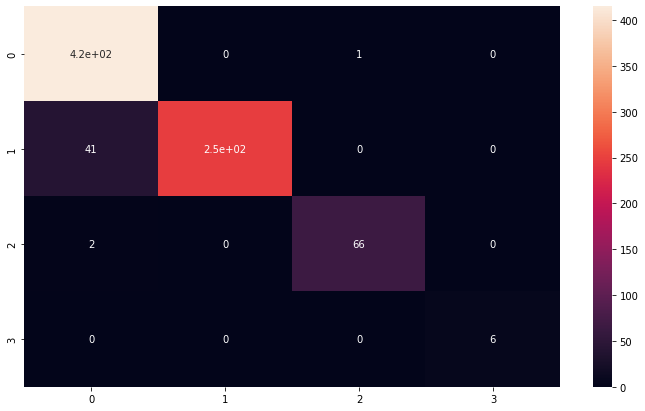

In [15]:

y_pred = []
y_true = []
'''
for i, (x_data, labels) in enumerate(test_loader):
        x_data, labels = x_data.to(device), labels.to(device)
        outputs = model(x_data)

'''
# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        labels = np.argmax(labels, axis=1)
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3')

print(y_pred)
print(y_true)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show